This dataset consists of information on 5,960 mortgage loans at a bank. These are loans where the borrower uses their property as collateral. The dataset includes the following fields:

    BAD: 1 = Loan record is delinquent or defaulted; 0 = Loan record is performing or paying off. => This is the target column to predict.
    LOAN: The requested loan amount.
    MORTDUE: The outstanding balance of the existing mortgage.
    VALUE: The current property value.
    REASON: DebtCon = debt consolidation; HomeImp = home improvement.
    JOB: Occupation.
    YOJ: Years of experience in the current job.
    DEROG: The number of derogatory reports (negative credit events).
    DELINQ: The number of overdue credit loans.
    CLAGE: The age of the oldest credit loan in months.
    NINQ: The number of recent credit inquiries.
    CLNO: The number of current credit loans.
    DEBTINC: The debt-to-income ratio.
    Goal: Build a logistic regression model to predict whether a loan will fall into label 1 (default) or label 0 (likely to repay).

In [1]:
import pandas as pd
import seaborn as sns

I. EDA

In [3]:
df = pd.read_csv("hmeq.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [7]:
df.shape

(5960, 13)

In [5]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [8]:
df.isna().sum()/df.shape[0]

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

In [4]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149



In this case, 11 out of 13 columns contain missing data, with the missing rate for each column being ≤ 21%. I can still use the columns with missing data by imputing the missing values. For numerical columns, I will replace the missing values with the mean, and for categorical columns, we will replace the missing values with the mode (most frequent value)

II. FEATURE ENGINEERING

Train validation split


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train,X_val,y_train,y_val = train_test_split(df.drop(columns=['BAD']),df['BAD'],test_size=0.2,random_state = 100,shuffle=True)

In [11]:
df.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [12]:
cat_cols = ['REASON','JOB']
num_cols = ['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']

In [13]:
# Impute missing values for categorical columns with the mode value of the column in X_train.
for col in cat_cols:
  X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
  X_val[col] = X_val[col].fillna(X_train[col].mode()[0])

In [14]:
# Impute missing values for numerical columns with the mean value of the column in X_train.
for col in num_cols:
  X_train[col] = X_train[col].fillna(X_train[col].mean())
  X_val[col] = X_val[col].fillna(X_train[col].mean())

One hot encoding

In [15]:
X_train = pd.get_dummies(X_train,columns=cat_cols,drop_first=True)
X_val = pd.get_dummies(X_val,columns=cat_cols,drop_first=True)

III. MODELING

In [22]:
import statsmodels.api as sm

In [19]:
X_train = X_train.applymap(lambda x: 1 if x == True else (0 if x == False else x))
X_val = X_val.applymap(lambda x: 1 if x == True else (0 if x == False else x))

/var/folders/k7/rljyypp9343__2xr47zglj2c0000gn/T/ipykernel_59960/3981204416.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.applymap(lambda x: 1 if x == True else (0 if x == False else x))
/var/folders/k7/rljyypp9343__2xr47zglj2c0000gn/T/ipykernel_59960/3981204416.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val = X_val.applymap(lambda x: 1 if x == True else (0 if x == False else x))


In [20]:
X_train = sm.add_constant(X_train)
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.393728
         Iterations 7


In [21]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    BAD   No. Observations:                 4768
Model:                          Logit   Df Residuals:                     4751
Method:                           MLE   Df Model:                           16
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                  0.2129
Time:                        12:24:26   Log-Likelihood:                -1877.3
converged:                       True   LL-Null:                       -2385.1
Covariance Type:            nonrobust   LLR p-value:                5.162e-206
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5410      0.295     -8.626      0.000      -3.118      -1.964
LOAN           -2.135e-05   4.66e-06     -4.580      0.000   -3.05e-05   -1.22e-05
MORTDUE        -4.011e-06   1.56e-06     -2.576      0.010   -7.06e-06   -9.59e-07
VALUE           4.355e-06    1.1e-06      3.967      0.000     2.2e-06    6.51e-06
YOJ               -0.0164      0.006     -2.542      0.011      -0.029      -0.004
DEROG              0.5523      0.053     10.382      0.000       0.448       0.657
DELINQ             0.7550      0.042     17.816      0.000       0.672       0.838
CLAGE             -0.0052      0.001     -8.593      0.000      -0.006      -0.004
NINQ               0.1691      0.023      7.304      0.000       0.124       0.215
CLNO              -0.0136      0.005     -2.805      0.005      -0.023      -0.004
DEBTINC            0.0518      0.007      7.678      0.000       0.039       0.065
REASON_HomeImp     0.2246      0.094      2.398      0.016       0.041       0.408
JOB_Office        -0.5561      0.167     -3.324      0.001      -0.884      -0.228
JOB_Other          0.0423      0.130      0.326      0.744      -0.212       0.296
JOB_ProfExe        0.0641      0.150      0.429      0.668      -0.229       0.357
JOB_Sales          1.0797      0.292      3.698      0.000       0.508       1.652
JOB_Self           0.5428      0.240      2.264      0.024       0.073       1.013
==================================================================================
"""

Next, we run the prediction on the training set

In [23]:
y_pred_train = log_reg.predict(X_train)

In [24]:
y_pred_train

5518    0.066901
25      0.268684
1324    0.064969
4466    0.136126
1901    0.687014
          ...   
350     0.108476
79      0.400290
3927    0.985824
5955    0.017869
5640    0.098989
Length: 4768, dtype: float64

I will use the default threshold of 0.5
- If p ≥ 0.5: predict as group 1 (default).
- If p < 0.5: predict as group 0 (likely to repay)

In [25]:
cutoff = 0.5
y_pred_train = (y_pred_train > cutoff).astype(int)

In [26]:
y_pred_train

5518    0
25      0
1324    0
4466    0
1901    1
       ..
350     0
79      0
3927    1
5955    0
5640    0
Length: 4768, dtype: int64

Similarly, I will make predictions on the validation set

In [27]:
X_val = sm.add_constant(X_val)
y_pred_val = log_reg.predict(X_val)
y_pred_val = (y_pred_val > cutoff).astype(int)

IV. MODEL EVALUATION

I calculate the metrics of accuracy, precision, recall, and F1 to evaluate the effectiveness of the classification model.

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
acc_train = accuracy_score(y_train,y_pred_train)
acc_val = accuracy_score(y_val,y_pred_val)


In [36]:
print(f"Accuracy of train set : {acc_train}")
print(f"Accuracy of val set: {acc_val}")

Accuracy of train set : 0.8378775167785235
Accuracy of val set: 0.837248322147651


In [32]:
precision_train = precision_score(y_train,y_pred_train)
precision_val = precision_score(y_val,y_pred_val)

In [37]:
print(f"Precision of train set : {precision_train}")
print(f"Precision of val set : {precision_val}")

Precision of train set : 0.725
Precision of val set : 0.71


In [34]:
recall_train = recall_score(y_train,y_pred_train)
recall_val = recall_score(y_val,y_pred_val)

In [38]:
print(f"Recall of train set : {recall_train}")
print(f"Recall of val set : {recall_val}")

Recall of train set : 0.304302203567681
Recall of val set : 0.3008474576271186


In [39]:
f1_train = f1_score(y_train,y_pred_train)
f1_val = f1_score(y_val,y_pred_val)

In [40]:
print(f"F1 score of train set : {f1_train}")
print(f"F1 score  of val set : {f1_val}")

F1 score of train set : 0.4286770140428677
F1 score  of val set : 0.4226190476190476


Looking at the results, we can see that there is no significant difference between the results on the train and validation sets, indicating that the model is not overfitting.

However, when examining the individual metrics, we find that precision is high (~72%), suggesting that the model is predicting group 1 (defaults) fairly accurately. On the other hand, recall is low, indicating that the model is missing a considerable number of cases where the true label is group 1 (but the model predicts group 0). The combination of high precision and low recall results in a low F1 score.

In practice, missing many default loans could lead to significant losses for the bank, so the bank would want to capture as many defaults as possible, meaning a higher recall is needed.

To increase recall, we could consider selecting a lower cutoff threshold.

In [60]:

import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [61]:

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_val)[:, 1]  

cutoffs = np.arange(0.0, 1.0, 0.01)

/Users/trangdang/Documents/Project/Linear Regression/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/trangdang/Documents/Project/Linear Regression/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/trangdang/Documents/Project/Linear Regression/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/trangdang/Documents/Project/Linear Regression/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

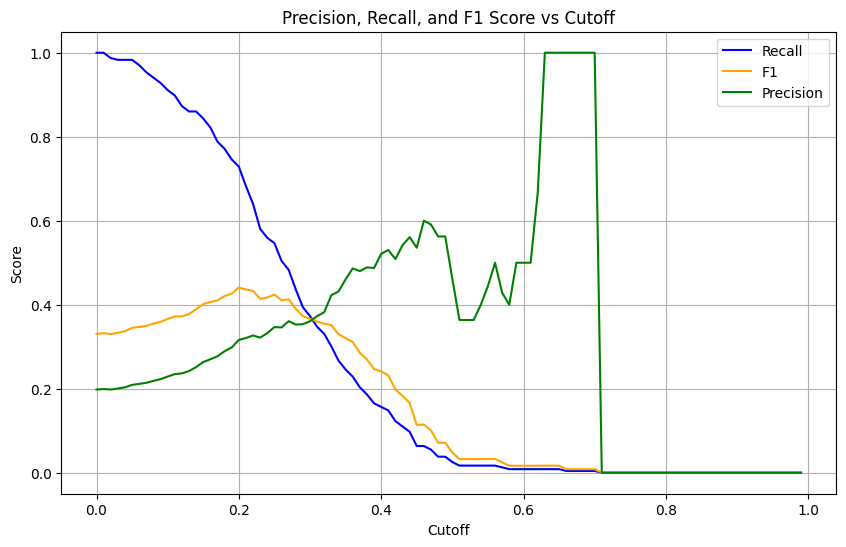

In [62]:
precision = []
recall = []
f1 = []
for cutoff in cutoffs:
    y_pred = (y_probs >= cutoff).astype(int)
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, recall, label='Recall', color='b', linestyle='-')
plt.plot(cutoffs, f1, label='F1', color='orange', linestyle='-')
plt.plot(cutoffs, precision, label='Precision', color='g', linestyle='-')

plt.title('Precision, Recall, and F1 Score vs Cutoff')
plt.xlabel('Cutoff')
plt.ylabel('Score')

plt.legend()

# Hiển thị grid và biểu đồ
plt.grid(True)
plt.show()